In [256]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

from scipy.stats import chi2_contingency, chi2, mannwhitneyu, kruskal, shapiro, ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as ss
import pingouin as pg

Кейс №2 - Приложение доставки

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

В данных вы найдете логи заказов пользователей:

- ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
- ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
- ab_products – подробная информация о продуктах, их название и стоимость

In [257]:
# выгружаем файлы с данными
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-shishkova/ab_orders.csv')
products = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-shishkova/ab_products.csv')
users_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-shishkova/ab_users_data.csv')

    Подготовим данные к анализу и проведению теста

In [258]:
# подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов,
# которые были включены в заказ
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [259]:
orders.shape

(4123, 3)

In [260]:
# проверяем уникальность
orders.nunique()

order_id         4123
creation_time    4098
product_ids      3877
dtype: int64

In [261]:
# проверяем пропущенные значения
orders.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [262]:
# смотрим информацию о данных
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB


In [263]:
orders.describe()

,order_id
count,4123.000000
mean,16387.899103
std,16644.518947
min,1255.000000
25%,2444.500000
50%,9614.000000
75%,27000.000000
max,59533.000000


In [264]:
orders['product_ids'].describe()

count     4123
unique    3877
top       {20}
freq        11
Name: product_ids, dtype: object

In [265]:
orders['creation_time'].describe()

count                           4123
unique                          4098
top       2022-08-26 01:24:04.000000
freq                               2
Name: creation_time, dtype: object

In [266]:
# приводим в формат даты
orders['creation_time'] = pd.to_datetime(orders.creation_time)

In [267]:
# проверяем
orders.dtypes

order_id                  int64
creation_time    datetime64[ns]
product_ids              object
dtype: object

In [268]:
# подробная информация о продуктах, их название и стоимость
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [269]:
products.shape

(87, 3)

In [270]:
# проверяем уникальность
products.nunique()

product_id    87
name          87
price         63
dtype: int64

In [271]:
# проверяем пропущенные значения
products.isna().sum()

product_id    0
name          0
price         0
dtype: int64

In [272]:
# смотрим информацию о данных
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [273]:
products.describe()

,product_id,price
count,87.000000,87.000000
mean,44.000000,133.581609
std,25.258662,136.127922
min,1.000000,1.000000
25%,22.500000,55.000000
50%,44.000000,76.300000
75%,65.500000,160.000000
max,87.000000,800.000000


In [274]:
products['name'].describe()

count        87
unique       87
top       сахар
freq          1
Name: name, dtype: object

In [275]:
# история заказов пользователей, в этой таблице есть информация о том, 
# какие заказы создавали и отменяли пользователи
users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [276]:
users_data.shape

(4337, 6)

In [277]:
# проверяем уникальность
users_data.nunique()

user_id     1017
order_id    4123
action         2
time        4312
date          14
group          2
dtype: int64

In [278]:
# видим 2 вида действия: созданные и отмененные заказы
users_data.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

In [279]:
# кол-во уникальных пользователей по группам 
# отличие незначительное, но  мы понимаем, 
# что пользователь может сделать заказ несколько раз
users_data.groupby('group', as_index=False).user_id.nunique()

,group,user_id
0,0,515
1,1,502


In [280]:
# проверяем пропущенные значения
users_data.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [281]:
# смотрим информацию о данных
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4337 non-null   int64 
 1   order_id  4337 non-null   int64 
 2   action    4337 non-null   object
 3   time      4337 non-null   object
 4   date      4337 non-null   object
 5   group     4337 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 203.4+ KB


In [282]:
# приводим в формат даты
users_data['time'] = pd.to_datetime(users_data.time)
users_data['date'] = pd.to_datetime(users_data.date)
users_data.dtypes

user_id              int64
order_id             int64
action              object
time        datetime64[ns]
date        datetime64[ns]
group                int64
dtype: object

In [283]:
users_data.describe()

,user_id,order_id,group
count,4337.000000,4337.000000,4337.000000
mean,1466.771270,16362.859811,0.610099
std,290.451607,16609.671919,0.487784
min,964.000000,1255.000000,0.000000
25%,1220.000000,2444.000000,0.000000
50%,1463.000000,9615.000000,1.000000
75%,1710.000000,26920.000000,1.000000
max,1980.000000,59533.000000,1.000000


In [284]:
users_data['action'].describe()

count             4337
unique               2
top       create_order
freq              4123
Name: action, dtype: object

In [285]:
users_data['date'].describe()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                    4337
unique                     14
top       2022-08-26 00:00:00
freq                     1384
first     2022-08-26 00:00:00
last      2022-09-08 00:00:00
Name: date, dtype: object

    У нас есть 2 группы пользователей:

    - группа_1 пользователи с новой системой рекомендаций, 
    - группе_0 пользователи со старой версией приложения, где нет рекомендации товаров.

In [286]:
users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


In [287]:
# посмотрим разницу отмены заказов по группам
user_action = users_data \
    .groupby(['group', 'action'], as_index=False) \
    .agg({'user_id': 'count'}) \
    .rename(columns={'user_id': 'count_orders'})
user_action

,group,action,count_orders
0,0,cancel_order,82
1,0,create_order,1609
2,1,cancel_order,132
3,1,create_order,2514


In [288]:
print('Процент отмененных заказов группы_0:', 
      round(user_action.count_orders[0] / user_action.count_orders[1] * 100, 2),'%')
print('Процент отмененных заказов группы_1:', 
      round(user_action.count_orders[2] / user_action.count_orders[3] * 100, 2),'%')

Процент отмененных заказов группы_0: 5.1 %
Процент отмененных заказов группы_1: 5.25 %


    Видим небольшую разницу отмененных заказов между группами. Далее будем анализировать тестирование 
    приложения старой и новой версий с созданными заказами.

In [289]:
# оставим в таблице только действующие заказы, отмененные нам не интересны
users_created = users_data.query('action == "create_order"')
users_created.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


In [290]:
 users_created.shape

(4123, 6)

In [291]:
orders.shape

(4123, 3)

In [292]:
# объединим таблицы по ид заказа
created_orders = users_created.merge(orders, on='order_id')

In [293]:
# создадим колонку месяц создания заказа и дропнем колонку время создания как повторяющуюся
created_orders['creation_month'] = created_orders.creation_time.dt.strftime('%Y-%m')
created_orders = created_orders.drop(columns=['creation_time'])
created_orders.head(3)

,user_id,order_id,action,time,date,group,product_ids,creation_month
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,"{75, 22, 53, 84}",2022-08
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,"{56, 76, 39}",2022-08
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,"{76, 34, 41, 38}",2022-08


In [294]:
# убираем скобки
created_orders.product_ids = created_orders.product_ids.str.strip('{}')

In [295]:
# разъединяем группы товаров по ид продукта
created_orders['product_ids']  = created_orders['product_ids'].str.split(',')
created_orders = created_orders \
    .explode('product_ids') \
    .rename(columns={'product_ids': 'product_id'})
created_orders.head(3)

,user_id,order_id,action,time,date,group,product_id,creation_month
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,75,2022-08
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,22,2022-08
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,53,2022-08


In [296]:
# приводим ид товара к формату целого числа
created_orders.product_id = created_orders.product_id.astype('int64')

In [297]:
# теперь обединяем таблицы по ид продукта
general_table = created_orders.merge(products, on='product_id')
general_table.shape

(13826, 10)

In [298]:
general_table.head()

,user_id,order_id,action,time,date,group,product_id,creation_month,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,75,2022-08,сок ананасовый,120.0
1,987,1287,create_order,2022-08-26 00:31:36,2022-08-26,0,75,2022-08,сок ананасовый,120.0
2,1073,1403,create_order,2022-08-26 03:01:40,2022-08-26,1,75,2022-08,сок ананасовый,120.0
3,1089,1424,create_order,2022-08-26 04:01:22,2022-08-26,1,75,2022-08,сок ананасовый,120.0
4,1139,1495,create_order,2022-08-26 06:04:05,2022-08-26,1,75,2022-08,сок ананасовый,120.0


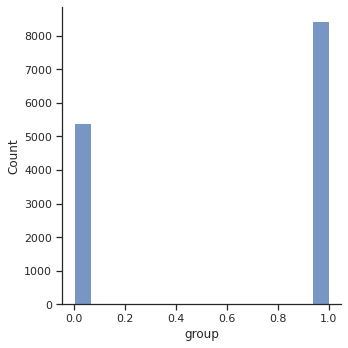

In [299]:
# визуализируем группы на графике
sns.set(style= 'ticks', rc={'figure.figsize': (20, 12)})
sns.displot(general_table, x='group')

In [300]:
# посчитаем выручку по группам
revenue = general_table \
    .groupby(['group'], as_index=False) \
    .agg({'price': 'sum'})

print('Выручка группы_1 больше выручки группы_0 на', 
      round(100 - revenue.price[0] / revenue.price[1] * 100, 2),'%, в сумме', 
      round(revenue.price[1] - revenue.price[0]),'руб')
revenue

Выручка группы_1 больше выручки группы_0 на 33.98 %, в сумме 315743 руб


,group,price
0,0,613488.8
1,1,929232.0


In [301]:
# посмотрим на разницу выручки по месяцам
revenue_month = general_table \
    .groupby(['creation_month', 'group'], as_index=False) \
    .agg({'price': 'sum'})

print('Август. Выручка группы_1 больше выручки группы_0 на', 
      round(100 - revenue_month.price[0] / revenue_month.price[1] * 100, 2),'%, в сумме', 
      round(revenue_month.price[1] - revenue_month.price[0]),'руб')
print('Сентябрь. Выручка группы_1 больше выручки группы_0 на', 
      round(100 - revenue_month.price[2] / revenue_month.price[3] * 100, 2),'%, в сумме', 
      round(revenue_month.price[3] - revenue_month.price[2]),'руб')
revenue_month

Август. Выручка группы_1 больше выручки группы_0 на 28.52 %, в сумме 168470 руб
Сентябрь. Выручка группы_1 больше выручки группы_0 на 43.52 %, в сумме 147273 руб


,creation_month,group,price
0,2022-08,0,422336.8
1,2022-08,1,590806.7
2,2022-09,0,191152.0
3,2022-09,1,338425.3


In [302]:
# проверим начало и окончание дат тестирования на совпадения
group_0 = general_table.query('group == 0')
group_1 = general_table.query('group == 1')
print('Дата начала тестирования группы_0:', group_0.time.min())
print('Дата окончания тестирования группы_0:', group_0.time.max())
print('Дата начала тестирования группы_1:', group_1.time.min())
print('Дата окончания тестирования группы_1:', group_1.time.max())

Дата начала тестирования группы_0: 2022-08-26 00:00:19
Дата окончания тестирования группы_0: 2022-09-08 23:41:24
Дата начала тестирования группы_1: 2022-08-26 00:02:21
Дата окончания тестирования группы_1: 2022-09-08 23:18:05


In [303]:
# посчитаем кол-во действий по дням 
action_count = general_table.groupby(['group', 'date'], as_index = False)\
        .agg({'action':'count'})
action_count.head()

,group,date,action
0,0,2022-08-26,2095
1,0,2022-08-27,393
2,0,2022-08-28,311
3,0,2022-08-29,376
4,0,2022-08-30,305


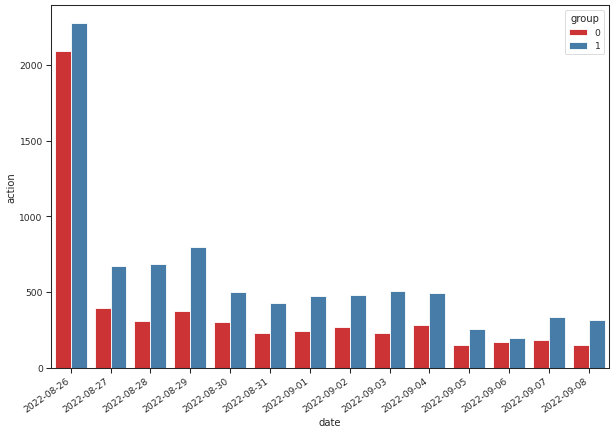

In [304]:
# визуализируем кол-во действий по дням и группам   
f, ax = plt.subplots(figsize=(12, 8), dpi= 60)
sns.barplot(data=action_count, x='date', y='action', hue='group', palette='Set1')
x_dates = action_count['date'].dt.strftime('%Y-%m-%d')
ax.set_xticklabels(labels=x_dates, rotation=35, ha='right')
plt.show()

    Группа_1 с новой системой рекомендаций товаров показывает рост.
    За весь период тестирования видим разницу выручки между группами в 33.98% в пользу группы_1, 
    а отдельно по месяцам наблюдаем разницу выручки с нарастающим эффектом. Также и по количеству действий 
    тоже виден ежедневный прирост.
    Далее будем рассматривать метрики за общий период тестирования, тк начало и окончание периода 
    для каждой группы совпадают. 
    
    Проанализируем отличие по группам, для этого рассмотрим: 
    - средний чек
    - общее количество заказов
    - топ-10 самых покупаемых пользователями товаров

In [305]:
# средний чек по группам
avg_price = general_table \
    .groupby(['group'], as_index=False) \
    .agg({'price': 'mean'}) \
    .rename(columns={'price': 'avg_price'})
print('Средний чек группы_1 на', 
      round(100 - avg_price.avg_price[1] / avg_price.avg_price[0] * 100, 2),'%', 
      'меньше, чем группы_0, разница', round(avg_price.avg_price[0] - avg_price.avg_price[1], 2),'руб')
avg_price

Средний чек группы_1 на 3.22 % меньше, чем группы_0, разница 3.67 руб


,group,avg_price
0,0,113.819814
1,1,110.150782


In [306]:
# кол-во заказов по группам
count_orders = general_table \
    .groupby(['group'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'orders'})
print('Количество заказов группы_1 на', 
      round(100 - count_orders.orders[0] / count_orders.orders[1] * 100, 2),'%', 'больше, чем группы_0,',
     count_orders.orders[1] - count_orders.orders[0],'заказа')
count_orders

Количество заказов группы_1 на 36.11 % больше, чем группы_0, 3046 заказа


,group,orders
0,0,5390
1,1,8436


In [307]:
# Топ-10 товаров группы_0
group_0_top = group_0 \
    .groupby(['name', 'price'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'orders_count'}) \
    .sort_values('orders_count', ascending=False)
group_0_top['revenue'] = group_0_top.price * group_0_top.orders_count
group_0_top_10 = group_0_top.head(10)
group_0_top_10

,name,price,orders_count,revenue
29,курица,298.4,127,37896.8
3,бананы,100.0,116,11600.0
72,хлеб,40.0,110,4400.0
5,батон,50.0,110,5500.0
41,масло подсолнечное,75.0,110,8250.0
27,кофе растворимый,150.0,107,16050.0
86,яблоки,75.4,106,7992.4
55,сахар,150.0,104,15600.0
78,чай черный в пакетиках,55.5,102,5661.0
66,сосиски,150.0,101,15150.0


In [308]:
# Топ-10 товаров группы_1
group_1_top = group_1 \
    .groupby(['name', 'price'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'orders_count'}) \
    .sort_values('orders_count', ascending=False)
group_1_top['revenue'] = group_1_top.price * group_1_top.orders_count
group_1_top_10 = group_1_top.head(10)
group_1_top_10

,name,price,orders_count,revenue
5,батон,50.0,183,9150.0
55,сахар,150.0,181,27150.0
50,печенье,45.5,179,8144.5
72,хлеб,40.0,178,7120.0
3,бананы,100.0,175,17500.0
65,соль,30.0,170,5100.0
35,макароны,98.0,164,16072.0
64,сок яблочный,120.0,161,19320.0
29,курица,298.4,160,47744.0
33,лимонад,90.4,160,14464.0


In [309]:
print('Выручка Топ-10 товаров группы_1 на', round(100 - 128100 / 171764 * 100, 2),'% выше, чем группы_0')
print('Выручка Топ-10 товаров группы_0 -', round(group_0_top_10.revenue.sum()),'руб')
print('Выручка Топ-10 товаров группы_1 -', round(group_1_top_10.revenue.sum()),'руб')
print('Кол-во товаров Топ-10 группы_1 на', round(100 - 1093 / 1711 * 100, 2),'% больше по сравнению с группой_0')
print('Кол-во товаров Топ-10 группы_0 -', group_0_top_10.orders_count.sum(),'шт')
print('Кол-во товаров Топ-10 группы_1 -', group_1_top_10.orders_count.sum(),'шт')
print('Средний чек Топ-10 группы_1 на', round(100 - 100.39 / 117.2 * 100, 2),
      '% меньше по сравнению с группой_0, разница', round(117.2 - 100.39, 2),'руб')
print('Средний  чек Топ-10 группы_0 -',  round(128100 / 1093, 2),'руб')
print('Средний  чек Топ-10 группы_1 -',  round(171764 / 1711, 2),'руб')

Выручка Топ-10 товаров группы_1 на 25.42 % выше, чем группы_0
Выручка Топ-10 товаров группы_0 - 128100 руб
Выручка Топ-10 товаров группы_1 - 171764 руб
Кол-во товаров Топ-10 группы_1 на 36.12 % больше по сравнению с группой_0
Кол-во товаров Топ-10 группы_0 - 1093 шт
Кол-во товаров Топ-10 группы_1 - 1711 шт
Средний чек Топ-10 группы_1 на 14.34 % меньше по сравнению с группой_0, разница 16.81 руб
Средний  чек Топ-10 группы_0 - 117.2 руб
Средний  чек Топ-10 группы_1 - 100.39 руб


    По всем показателям группы_1 очевидно, что приложение с новой системой рекомендаций товаров 
    показывает прекрасные результаты по увеличению количества продаж и роста выручки,  средний чек 
    за весь период тестирования незначительно ниже группы_0, скорее всего это произошло в виду увеличения 
    заказов с низкой ценой товара, это более заметно в анализе Топ-10 самых популярных товаров.
    
    Давайте с помощью АБ-теста проверим наши расчеты. Для этого мы воспользуемся методом Стьюдента 
    Т-тест (сравнение средних значений).
    
    Определим метрики для тестирования:
        1 - средний чек заказа одного пользователя
        2 - среднее кол-во товаров в чеке одного пользователя
        3 - среднее кол-во заказов одним пользователем

In [310]:
general_table.head(2)

,user_id,order_id,action,time,date,group,product_id,creation_month,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,75,2022-08,сок ананасовый,120.0
1,987,1287,create_order,2022-08-26 00:31:36,2022-08-26,0,75,2022-08,сок ананасовый,120.0


In [311]:
# сумма чека на одного пользователя 
total_sum = general_table \
    .groupby(['user_id', 'order_id', 'group'], as_index=False) \
    .agg({'price': 'sum'}) \
    .rename(columns={'price': 'total'})
total_sum.head()

,user_id,order_id,group,total
0,964,1255,0,408.7
1,964,1257,0,310.2
2,965,1256,1,250.5
3,965,3946,1,860.6
4,965,9097,1,608.2


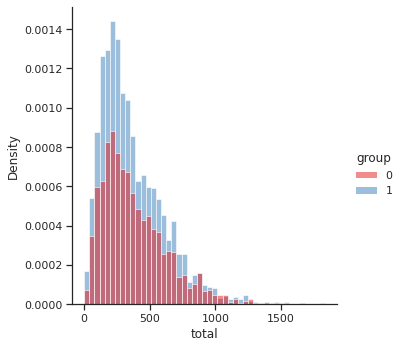

In [312]:
# визуализируем полученные данные
sns.set(style= 'ticks', rc={'figure.figsize': (20, 12)})
sns.displot(total_sum, x="total", hue="group", stat="density", palette="Set1")

In [313]:
# средний чек на одного пользователя 
total_sum.groupby('group', as_index=False).total.mean()

,group,total
0,0,381.285768
1,1,369.622912


    1. Видим незначительную разницу среднего чека между группами.
    Сформулируем гипотезу:
    - Нулевая гипотеза - средний чек в группах не отличается
    - Альтернативная гипотеза - средний чек в группах отличается    

In [315]:
ss.ttest_ind(total_sum.query('group == 1').total, total_sum.query('group == 0').total)

Ttest_indResult(statistic=-1.4815692121713073, pvalue=0.13853141121218765)

    По результату T-tеста нулевую гипотезу не отвергаем, т.е средний чек в группах не отличается. 
    
    2. Тестируем среднее кол-во товаров в чеке одного пользователя
    Сформулируем гипотезу:
    - Нулевая гипотеза - среднее кол-во товаров в чеке одного пользователя по группам не отличается
    - Альтернативная гипотеза - среднее кол-во товаров в чеке одного пользователя по группам отличается     

In [316]:
# кол-во товаров в чеке одного пользователя
product_count = general_table \
    .groupby(['user_id', 'order_id', 'group'], as_index=False) \
    .agg({'product_id': 'count'}) \
    .rename(columns={'product_id': 'product_count'})
avg_orders.head(3)

,user_id,order_id,group,product_count
0,964,1255,0,4
1,964,1257,0,4
2,965,1256,1,3


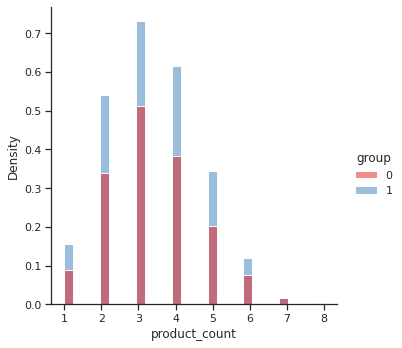

In [317]:
# визуализируем полученные данные
sns.set(style= 'ticks', rc={'figure.figsize': (20, 12)})
sns.displot(product_count, x="product_count", hue="group", stat="density", palette="Set1")

In [318]:
# среднее кол-во товаров в чеке одного пользователя
product_count.groupby('group', as_index=False).product_count.mean()

,group,product_count
0,0,3.349907
1,1,3.355609


In [319]:
ss.ttest_ind(product_count.query('group == 1').product_count, product_count.query('group == 0').product_count)

Ttest_indResult(statistic=0.1380397717649213, pvalue=0.8902157292521864)

    По результату T-tеста нулевую гипотезу не отвергаем, т.е среднее кол-во товаров в чеке одного 
    пользователя в группах не отличается. 

    3. Тестируем среднее среднее кол-во заказов одним пользователем
    Сформулируем гипотезу:
    - Нулевая гипотеза - среднее кол-во заказов одним пользователем по группам не отличается
    - Альтернативная гипотеза - среднее кол-во заказов одним пользователем по группам отличается     

In [320]:
general_table.head(2)

,user_id,order_id,action,time,date,group,product_id,creation_month,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,75,2022-08,сок ананасовый,120.0
1,987,1287,create_order,2022-08-26 00:31:36,2022-08-26,0,75,2022-08,сок ананасовый,120.0


In [322]:
# кол-во заказов одним пользователем
order_unique = general_table \
    .groupby(['user_id', 'group'], as_index=False) \
    .agg({'order_id': 'nunique'}) \
    .rename(columns={'order_id': 'order_unique'})
order_unique.head()

,user_id,group,order_unique
0,964,0,2
1,965,1,9
2,966,0,1
3,967,1,5
4,968,0,3


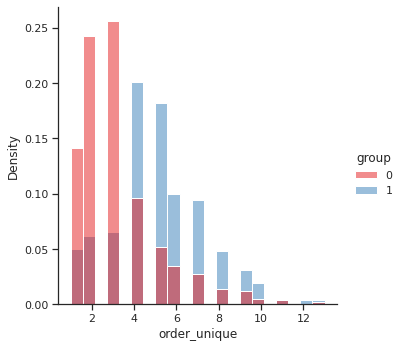

In [323]:
# визуализируем полученные данные
sns.set(style= 'ticks', rc={'figure.figsize': (20, 12)})
sns.displot(order_unique, x="order_unique", hue="group", stat="density", palette="Set1")

In [324]:
# среднее кол-во заказов одним пользователем
order_unique.groupby('group', as_index=False).order_unique.mean()

,group,order_unique
0,0,3.124272
1,1,5.007968


In [325]:
ss.ttest_ind(order_unique.query('group == 1').order_unique, order_unique.query('group == 0').order_unique)

Ttest_indResult(statistic=14.51086812343365, pvalue=1.6974865514796019e-43)

    Результат:
    Теперь однозначно можно отвергнуть нулевую гипотезу, тк pvalue=1.6974865514796019e-43 значительно 
    меньше 0.05 и сделать вывод, что среднее кол-во заказов одним пользователем по группам отличается.

#    Аналитическое заключение: 
    
    однозначно стоит включать новую систему рекомендаций для всех пользователей. 
    Новая система рекомендаций принесет пользу бизнесу и пользователям приложения, она поможет 
    пользователям эффективнее работать с приложением и лучше находить необходимые товары, а бизнесу увеличит 
    оборот товаров и колоссальное увеличение выручки.
    
    На основе моих исследований и расчетов (Топ-10 востребованных товаров) можно поработать над 
    увеличением среднего чека в группе_1, например: на главной странице приложения проводить 
    скидочные акции дорогостоящих товаров для увеличения чека и поддержать это мероприятие 
    пуш-рассылкой и тд.